# L'analyse de sentiments

L'analyse des sentiments est l'une des méthodes les plus populaires pour analyser un texte. 
Elle permet d'apprécier le sentiment exprimé par l'auteur du texte. Cela permet d'avoir une meilleure vue d'ensemble sur son assentiment lors de la rédaction de son texte ou de son document. C'est un excellent d'apprécier l'état émotionnel de l'auteur. 

# Importer les bibliothèques nécessaires 


In [1]:
from datasets import load_dataset
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from scipy import stats

# Télécharger les resources nécessaires pour VADER et Instancier l'analyseur VADER

In [2]:
# Télécharger les ressources nécessaires pour VADER
nltk.download("vader_lexicon")

# Instancier l'analyseur VADER
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to C:\Users\Houphouet
[nltk_data]     Kouadio\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Importer les données d'entrainement et de test 
L'ensemble de données porte sur l'avis des consommateurs sur Amazon. Les données couvrent une période de 18 ans, dont environ 3,5 millions d'avis jusqu'en mars 2013. Les avis incluent des informations sur les produits et les utilisateurs, des notes et un avis en texte brut.

In [3]:
# Charger le jeu de données
amazon = load_dataset("fancyzhx/amazon_polarity")
amazon

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

# Prétraitement des données 
Les données étant importante, un échantillonnage sera faite en vue de faciliter l'éxécution du code sur l'ordinateur. 

Selection les 5000 lignes de données aussi bien de train (entrainement) que de test (validation)

In [4]:
# Prétraitement des données
def preprocess_data(dataset, num_samples=5000):
    data = dataset.shuffle(seed=42).select(range(num_samples))
    texts = data["content"]
    labels = data["label"]
    return texts, labels

# Échantillonnage des données d'entraînement et de test
train_texts, train_labels = preprocess_data(amazon["train"], 5000)
test_texts, test_labels = preprocess_data(amazon["test"], 5000)

# Calcul des scores de sentiement sur avec les données train et test

In [5]:
# Fonction pour calculer les scores de sentiment
def compute_sentiment_scores(texts):
    vader_neg, vader_neu, vader_pos, vader_compound = [], [], [], []
    textblob_polarity, textblob_subjectivity = [], []

    for review in texts:
        # Scores VADER
        vader_sent = analyzer.polarity_scores(review)
        vader_neg.append(vader_sent["neg"])
        vader_neu.append(vader_sent["neu"])
        vader_pos.append(vader_sent["pos"])
        vader_compound.append(vader_sent["compound"])

        # Scores TextBlob
        textblob_sent = TextBlob(review).sentiment
        textblob_polarity.append(textblob_sent.polarity)
        textblob_subjectivity.append(textblob_sent.subjectivity)

    return pd.DataFrame({
        "vader_neg": vader_neg,
        "vader_neu": vader_neu,
        "vader_pos": vader_pos,
        "vader_compound": vader_compound,
        "textblob_polarity": textblob_polarity,
        "textblob_subjectivity": textblob_subjectivity
    })

# Calcul des scores pour les ensembles train et test
train_scores = compute_sentiment_scores(train_texts)
test_scores = compute_sentiment_scores(test_texts)

# Afficher les scores des sentiments des données train

In [6]:
train_scores

,vader_neg,vader_neu,vader_pos,vader_compound,textblob_polarity,textblob_subjectivity
0,0.044,0.745,0.211,0.9515,0.298333,0.714167
1,0.099,0.840,0.062,-0.2091,0.084762,0.481905
2,0.046,0.723,0.231,0.8878,0.237374,0.378283
3,0.020,0.892,0.088,0.8268,-0.088194,0.404861
4,0.049,0.844,0.107,0.6330,0.373016,0.623016
...,...,...,...,...,...,...
4995,0.084,0.805,0.111,0.1779,0.500000,0.500000
4996,0.077,0.749,0.174,0.6643,-0.206250,0.481250
4997,0.081,0.884,0.035,-0.8043,0.033654,0.400000
4998,0.029,0.757,0.214,0.9336,0.233333,0.295238


# Afficher les scores des sentiments des données test

In [7]:
test_scores

,vader_neg,vader_neu,vader_pos,vader_compound,textblob_polarity,textblob_subjectivity
0,0.104,0.769,0.126,0.1531,0.283333,0.360000
1,0.094,0.806,0.100,0.1159,0.066667,0.600000
2,0.021,0.826,0.153,0.8765,0.256944,0.506944
3,0.072,0.928,0.000,-0.4215,0.000000,0.000000
4,0.227,0.710,0.063,-0.9154,-0.322727,0.639394
...,...,...,...,...,...,...
4995,0.101,0.829,0.069,-0.4592,0.052885,0.548718
4996,0.080,0.805,0.115,0.2732,0.195000,0.565000
4997,0.038,0.842,0.120,0.6801,0.062500,0.470833
4998,0.055,0.945,0.000,-0.1027,-0.071429,0.214286


# Décompte des sentiments 

In [8]:
# Nombre total de chaque sentiment pour VADER
vader_totals = {
    "negatif_train": (train_scores["vader_neg"] > 0).sum(),
    "negatif_test": (test_scores["vader_neg"] > 0).sum(),
    "neutre_train": (train_scores["vader_neu"] > 0).sum(),
    "neutre_test": (test_scores["vader_neu"] > 0).sum(),
    "positif_train": (train_scores["vader_pos"] > 0).sum(),
    "positif_test": (test_scores["vader_pos"] > 0).sum()
}

# Nombre total de chaque sentiment pour TextBlob
textblob_totals = {
    "polarite_positive_train": (train_scores["textblob_polarity"] > 0).sum(),
    "polarite_positive_test": (test_scores["textblob_polarity"] > 0).sum(),
    "polarite_negative_train": (train_scores["textblob_polarity"] < 0).sum(),
    "polarite_negative_test": (test_scores["textblob_polarity"] < 0).sum(),
    "subjectivite_train": (train_scores["textblob_subjectivity"] > 0.5).sum(),
    "subjectivite_test": (test_scores["textblob_subjectivity"] > 0.5).sum()
}

# Affichage des résultats
print("Nombre total des sentiments pour VADER :")
for sentiment, total in vader_totals.items():
    print(f"{sentiment.capitalize()} : {total}")

print("\nNombre total des sentiments pour TextBlob :")
for sentiment, total in textblob_totals.items():
    print(f"{sentiment.replace('_', ' ').capitalize()} : {total}")


Nombre total des sentiments pour VADER :
Negatif_train : 3626
Negatif_test : 3602
Neutre_train : 5000
Neutre_test : 5000
Positif_train : 4624
Positif_test : 4604

Nombre total des sentiments pour TextBlob :
Polarite positive train : 3785
Polarite positive test : 3813
Polarite negative train : 1103
Polarite negative test : 1053
Subjectivite train : 2811
Subjectivite test : 2749


# Distributions comparatives des scores de sentiments train et test

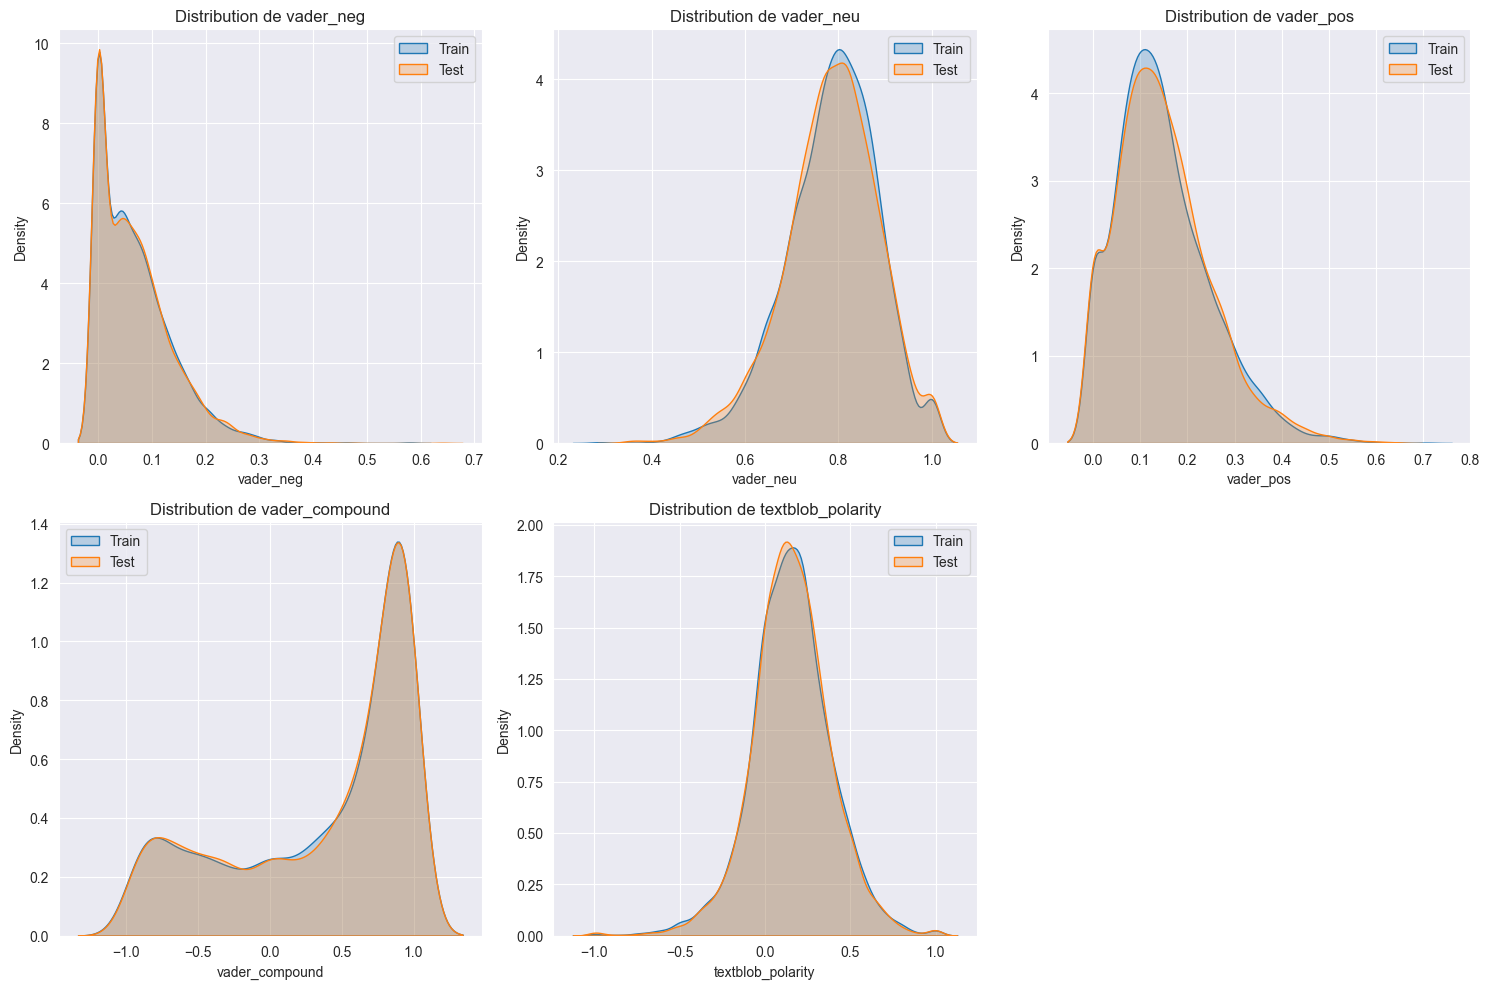

In [9]:
# Fonction pour analyser les distributions
def plot_distributions(train_scores, test_scores):
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(train_scores.columns[:-1]):  # Exclure "label"
        plt.subplot(2, 3, i + 1)
        sns.kdeplot(train_scores[column], label="Train", fill=True)
        sns.kdeplot(test_scores[column], label="Test", fill=True)
        plt.title(f"Distribution de {column}")
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_distributions(train_scores, test_scores)

# Test statistique de Kolmogorov-Smirnov pour vérifier l'effet des données sur les scores de sentiment
Les résultats montres que les distributions sont similaires. Il n'y a donc pas de différence de sentiments entre les données test et train

In [10]:
# Test statistique pour vérifier la similarité des distributions
print("\nTests statistiques de Kolmogorov-Smirnov entre train et test:")
for column in train_scores.columns[:-1]:  # Exclure "label"
    statistic, pvalue = stats.ks_2samp(train_scores[column], test_scores[column])
    print(f"{column}:")
    print(f"  Statistique KS: {statistic:.4f}")
    print(f"  p-value: {pvalue:.4f}")
    if pvalue < 0.05:
        print("  Les distributions sont significativement différentes.")
    else:
        print("  Les distributions sont similaires.")


Tests statistiques de Kolmogorov-Smirnov entre train et test:
vader_neg:
  Statistique KS: 0.0070
  p-value: 0.9997
  Les distributions sont similaires.
vader_neu:
  Statistique KS: 0.0232
  p-value: 0.1356
  Les distributions sont similaires.
vader_pos:
  Statistique KS: 0.0214
  p-value: 0.2024
  Les distributions sont similaires.
vader_compound:
  Statistique KS: 0.0096
  p-value: 0.9753
  Les distributions sont similaires.
textblob_polarity:
  Statistique KS: 0.0110
  p-value: 0.9229
  Les distributions sont similaires.


# Prédire les scores de sentiment des données test à partir des données train


### Ajouter les labels

In [11]:
# Ajouter les labels pour le machine learning
train_scores["label"] = train_labels
test_scores["label"] = test_labels

### Préparer les features et les labels 

In [12]:
# Préparation des features et labels
X_train = train_scores.drop(columns="label")
y_train = train_scores["label"]
X_test = test_scores.drop(columns="label")
y_test = test_scores["label"]

### Création et optimisation des modèles

In [13]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
}

param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [10, 20]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
}

best_models = {}

for name, model in models.items():
    print(f"Optimisation de {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Meilleurs paramètres pour {name}: {grid_search.best_params_}")

Optimisation de Logistic Regression...
Meilleurs paramètres pour Logistic Regression: {'C': 10}
Optimisation de Random Forest...
Meilleurs paramètres pour Random Forest: {'max_depth': 10, 'n_estimators': 200}
Optimisation de SVM...
Meilleurs paramètres pour SVM: {'C': 10, 'kernel': 'linear'}


### Comparaison des modèles

In [14]:
# Comparaison des modèles et détermination du meilleur
best_model_name = None
best_accuracy = 0

print("\nÉvaluation des modèles et comparaison:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} - Rapport de classification:")
    print(classification_report(y_test, y_pred))
    print(f"Précision: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

# Afficher le meilleur modèle
print("\nMeilleur modèle parmi ceux testés:")
print(f"Le modèle {best_model_name} a obtenu la meilleure précision avec un score de {best_accuracy:.4f}.")


# Évaluation des modèles et sélection du meilleur
#best_score = 0
#best_model_name = None

#for name, model in best_models.items():
#    score = model.score(X_test, y_test)
#    print(f"Score de {name}: {score:.4f}")
#    if score > best_score:
#         best_score = score
#         best_model_name = name
# 
# print(f"\nMeilleur modèle: {best_model_name} avec un score de {best_score:.4f}")



Évaluation des modèles et comparaison:

Logistic Regression - Rapport de classification:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      2453
           1       0.79      0.76      0.77      2547

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000

Précision: 0.7732

Random Forest - Rapport de classification:
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      2453
           1       0.79      0.72      0.75      2547

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000

Précision: 0.7606

SVM - Rapport de classification:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      2453
           1       0.80      0.75

# Prédire un nouveau cas de sentiment pour un nouveau commentaire

In [15]:

# Utiliser le meilleur modèle pour les prédictions
best_model = best_models[best_model_name]
y_pred = best_model.predict(X_test)
probas = best_model.predict_proba(X_test)

# Fonction pour convertir les prédictions numériques en labels textuels
def get_sentiment_label(prediction):
    sentiment_map = {0: "négatif", 1: "neutre", 2: "positif"}
    return sentiment_map[prediction]

# Afficher quelques exemples de prédictions
print("\nExemples de prédictions:")
for i in range(min(10, len(y_test))):  
    true_sentiment = get_sentiment_label(y_test.iloc[i])
    pred_sentiment = get_sentiment_label(y_pred[i])
    max_proba = max(probas[i])
    
    print(f"\nExemple {i+1}:")
    print(f"Scores: {dict(X_test.iloc[i])}")
    print(f"Sentiment réel: {true_sentiment}")
    print(f"Sentiment prédit: {pred_sentiment}")
    print(f"Probabilité: {max_proba:.2f}")

# Afficher le rapport de classification
# D'abord, identifions les classes présentes dans nos données
classes_presentes = sorted(list(set(y_test)))
noms_classes = ['négatif', 'neutre'] if len(classes_presentes) == 2 else ['négatif', 'neutre', 'positif']

print("\nDistribution des classes dans l'ensemble de test:")
print(pd.Series(y_test).value_counts())


# Fonction pour prédire le sentiment de nouveaux cas
def predict_sentiment_from_scores(scores, model):
    """
    Prédit le sentiment à partir des scores
    
    Parameters:
    scores (dict ou pandas Series): Les scores d'entrée
    model: Le modèle entraîné
    
    Returns:
    str: Le sentiment prédit ('positif', 'négatif', ou 'neutre')
    float: La probabilité de la prédiction
    """
    # Convertir en DataFrame si nécessaire
    if isinstance(scores, dict):
        scores = pd.DataFrame([scores])
    elif isinstance(scores, pd.Series):
        scores = pd.DataFrame([scores])
    
    # Faire la prédiction
    prediction = model.predict(scores)[0]
    probabilities = model.predict_proba(scores)[0]
    max_prob = max(probabilities)
    
    # Convertir la prédiction numérique en texte
    sentiment_map = {0: "négatif", 1: "neutre", 2: "positif"}
    predicted_sentiment = sentiment_map[prediction]
    
    return predicted_sentiment, max_prob

# Exemple d'utilisation pour un nouveau cas
print("\nPrédiction pour un nouveau cas:")
nouveau_cas = X_test.iloc[0]  # Premier cas de test comme exemple
sentiment, proba = predict_sentiment_from_scores(nouveau_cas, best_model)
print(f"Scores d'entrée: {dict(nouveau_cas)}")
print(f"Sentiment prédit: {sentiment}")
print(f"Probabilité: {proba:.2f}")


Exemples de prédictions:

Exemple 1:
Scores: {'vader_neg': np.float64(0.104), 'vader_neu': np.float64(0.769), 'vader_pos': np.float64(0.126), 'vader_compound': np.float64(0.1531), 'textblob_polarity': np.float64(0.2833333333333333), 'textblob_subjectivity': np.float64(0.36)}
Sentiment réel: neutre
Sentiment prédit: négatif
Probabilité: 0.54

Exemple 2:
Scores: {'vader_neg': np.float64(0.094), 'vader_neu': np.float64(0.806), 'vader_pos': np.float64(0.1), 'vader_compound': np.float64(0.1159), 'textblob_polarity': np.float64(0.06666666666666665), 'textblob_subjectivity': np.float64(0.6)}
Sentiment réel: négatif
Sentiment prédit: négatif
Probabilité: 0.73

Exemple 3:
Scores: {'vader_neg': np.float64(0.021), 'vader_neu': np.float64(0.826), 'vader_pos': np.float64(0.153), 'vader_compound': np.float64(0.8765), 'textblob_polarity': np.float64(0.2569444444444444), 'textblob_subjectivity': np.float64(0.5069444444444444)}
Sentiment réel: négatif
Sentiment prédit: neutre
Probabilité: 0.69

Exempl